# LSST Solar System Processing

## Linking of Observations from JPL Veres & Chesley dataset via HelioLinC2

### Algorithm: 

Based on HelioLinC (Holman et al. 2018) we transform topocentric observations to heliocentric states assuming a distance and radial velocity.
The resulting 3D positions are collected into tracklets. Tracklets contain at least two observations and can, thus, be used to create velocity vectors.
A tracklet + velocity vector is called an "arrow". 
Arrows are propagated to a common epoch using spiceypy's 2body propagator, and then clustered using dbscan.

### Implementation:
S. Eggl 20191215
    

In [1]:
# Solar System Processing functions
import heliolinc2 as hl

In [2]:
# Accelerators
import numpy as np

# Database
import pandas as pd

# Operating system interface
import os

In [3]:
# Joblib prallelization
import joblib
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects
from joblib import Parallel, delayed

In [4]:
# Progress bar for joblib processes
import contextlib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback:
        def __init__(self, time, index, parallel):
            self.index = index
            self.parallel = parallel

        def __call__(self, index):
            tqdm_object.update()
            if self.parallel._original_iterator is not None:
                self.parallel.dispatch_next()

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()   

## SIMULATED OBSERVATIONS 


### Select observations from JPL Dataset

Veres & Chesley 2017, 5deg x 5deg, 14 days 

In [5]:
data_dir='examples/data/'
fnobservations='Veres_5x5deb_14nights.csv.gz'

In [6]:
dfjpl= pd.read_csv(os.path.join(data_dir, fnobservations), sep=',').dropna().astype({'objId': 'int64','night': 'int32', 'obsId':'int64'} )

### Extract epochs of observations and query JPL Horizons for the corresponding observer states

In [7]:
#Observer location MPC code
observer_location='I11'
#Epochs of observation
obs_epochs=hl.transforms.mjd2jd(dfjpl['time'].values)
#time between observations
ephemeris_dt='1h'

In [8]:
[observer_xyz, observer_vxyz]=hl.ephemeris.getObserverStates(obs_epochs,observer_location,ephemeris_dt)

In [9]:
dfobs=dfjpl

### Add observer states to observations DataFrame

In [10]:
dfobs['x_obs']=observer_xyz[:,0]
dfobs['y_obs']=observer_xyz[:,1]
dfobs['z_obs']=observer_xyz[:,2]
dfobs['vx_obs']=observer_vxyz[:,0]
dfobs['vy_obs']=observer_vxyz[:,1]
dfobs['vz_obs']=observer_vxyz[:,2]

### Check observation dataframe: must contain time, RA, DEC, x_obs, y_obs, z_obs, vx_obs, vy_obs, vz_obs, night, obsId, objId

In [11]:
dfobs.head()

,obj,time,RA,DEC,x_obs,y_obs,z_obs,vx_obs,vy_obs,vz_obs,night,obsId,objId
0,S1009GjOa,52391.002282,171.368899,-12.504937,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0,0,839
1,S1001QUsa,52391.002282,169.318742,-13.021633,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0,1,164
2,S10036B8a,52391.002282,170.375067,-12.218251,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0,2,319
3,S100aAWQa,52391.002282,171.392970,-14.233830,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0,3,1580
4,S1001DTsa,52391.002282,171.308411,-14.222651,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0,4,144


### Analyze LSST Field

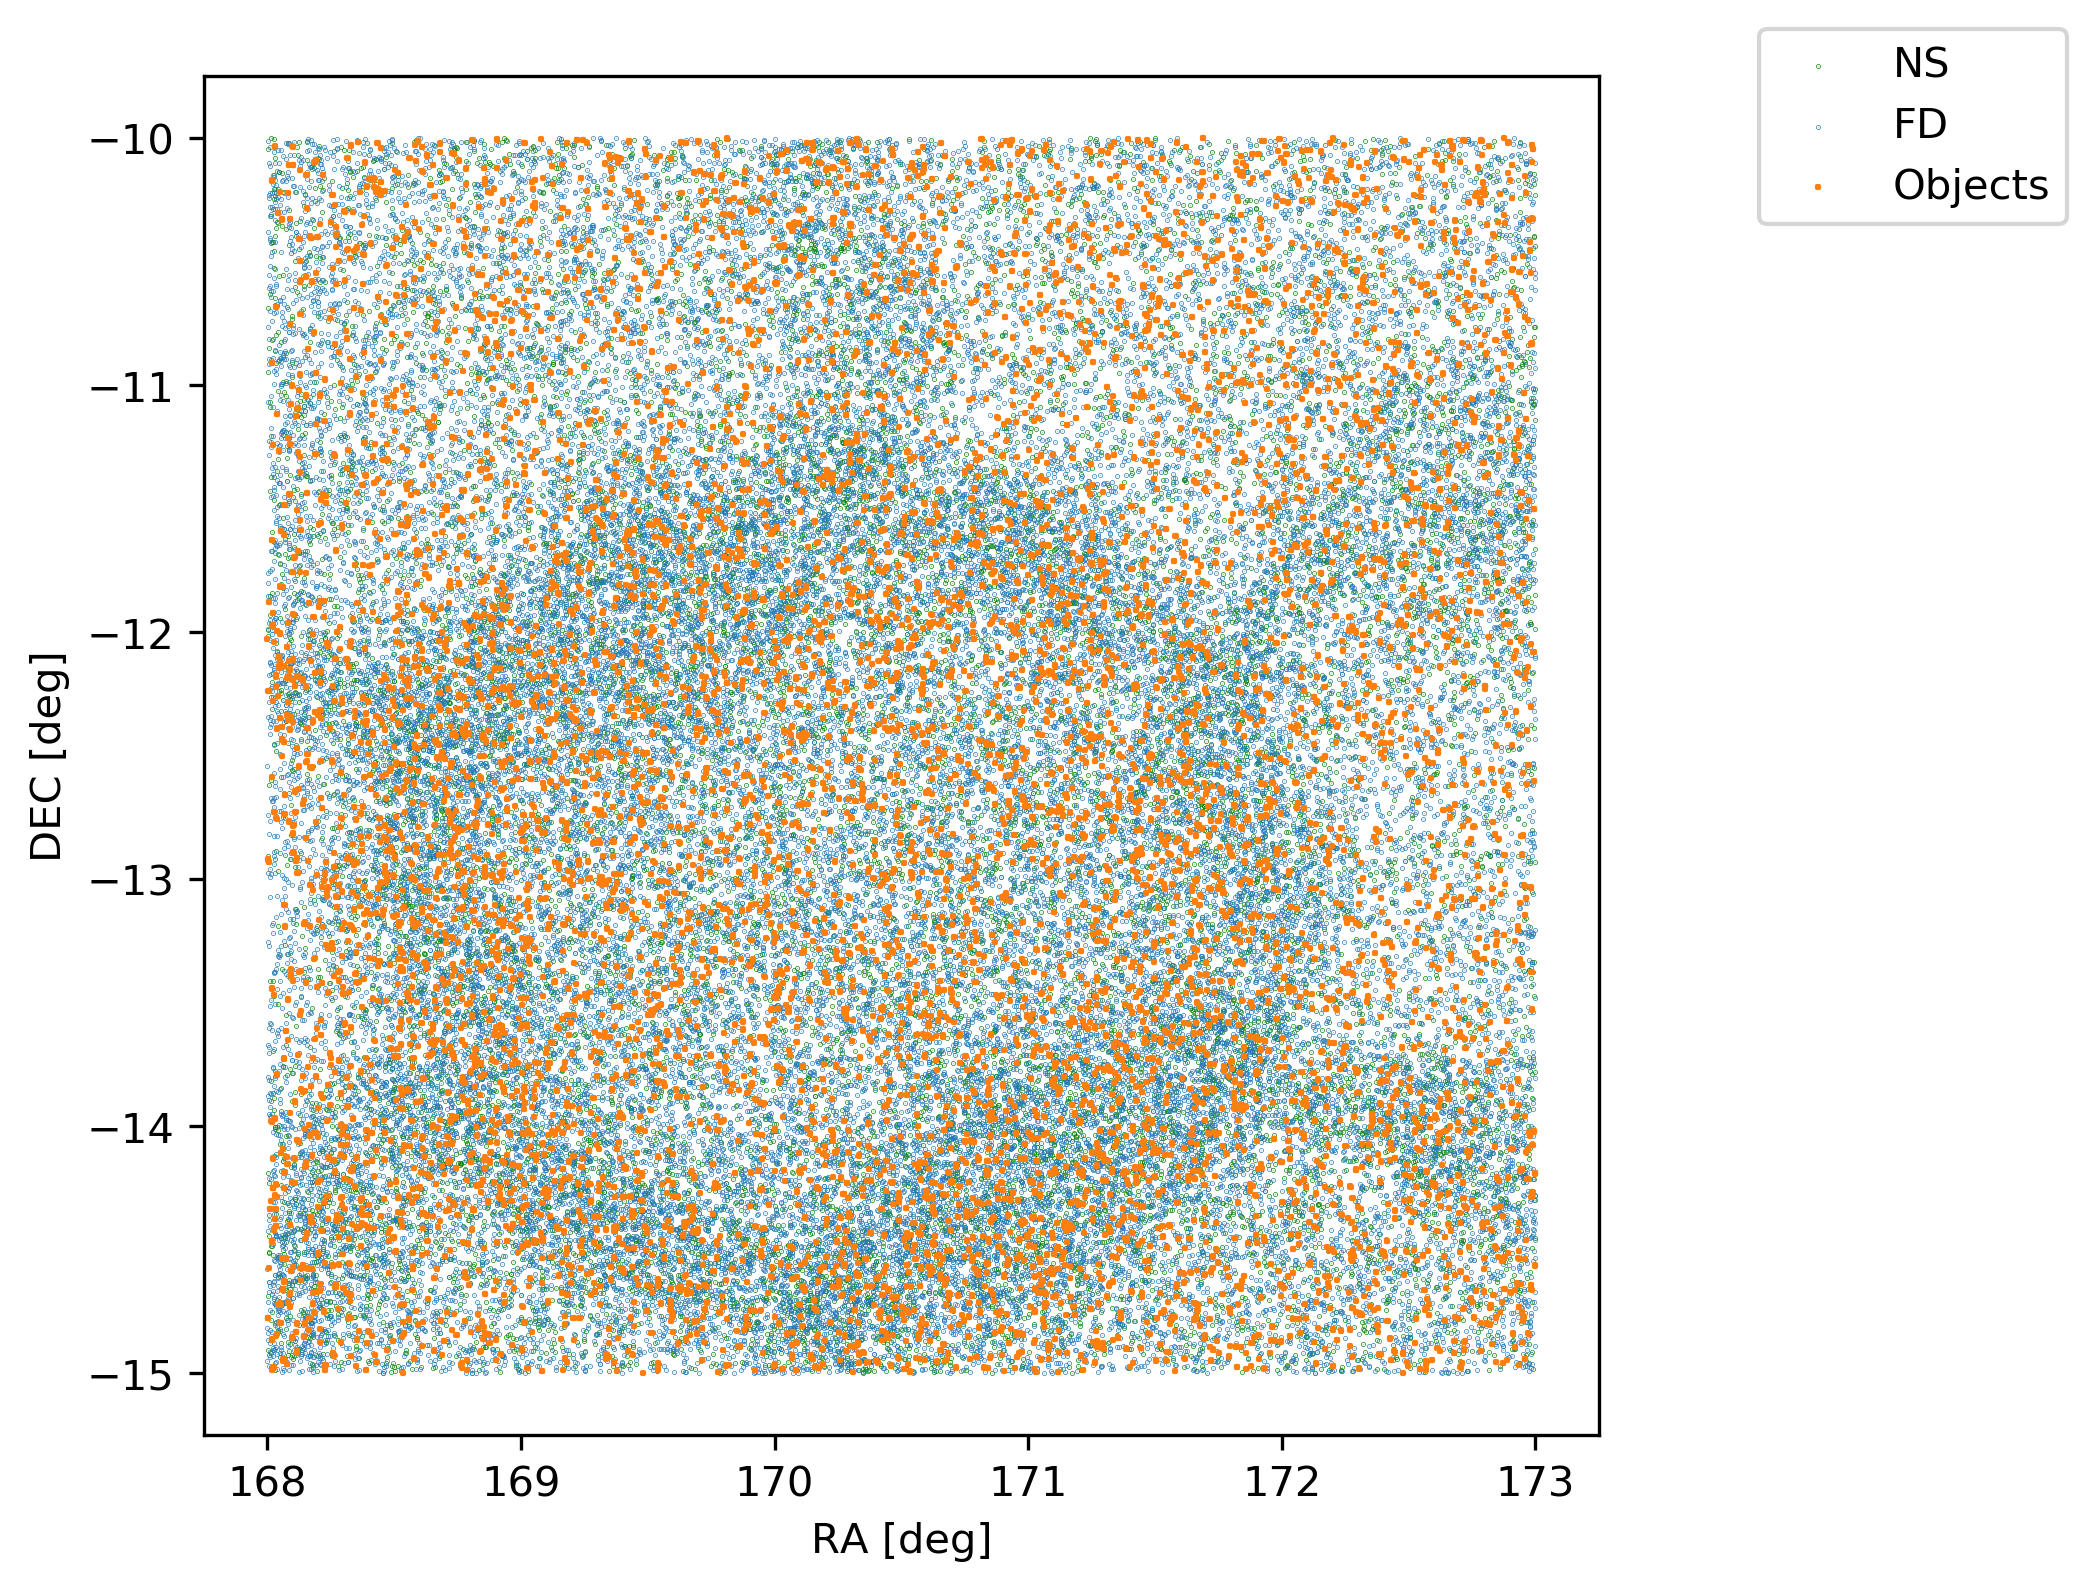

In [12]:
hl.plot.plot_field(dfobs)

### Signal to Noise in the chosen field 

In [13]:
# collect data from different categories
dfobs_FD=dfobs.iloc[dfobs['obj'].values=='FD']
dfobs_NS=dfobs.iloc[dfobs['obj'].values=='NS']
dfobs_obj=dfobs.drop(dfobs_FD.index).drop(dfobs_NS.index)
SNR_field=len(dfobs_obj.index)/(len(dfobs_NS.index)+len(dfobs_FD.index))
print(np.round(SNR_field,2))

0.27


### Source Density per square degree


In [14]:
np.rint(len(dfobs.index)/(5*5))

3108.0

### Since we are looking at a fraction of the sky, how many nights do we actually observe?

In [15]:
df_grouped_by_night=dfobs.groupby('night')

In [16]:
len(df_grouped_by_night.groups)

7

In [17]:
df_grouped_by_night.groups.keys()

dict_keys([0, 1, 3, 6, 10, 11, 13])

## Run HelioLinC2

### Choose HelioLinC2 clustering parameters

In [18]:
# Clustering radius for heliocentric positions projected from observations [au]
cr_obs=0.008
# Clustering radius for propagated arrows [au]
cr_arrows=0.002
# max temporal separation for tracklet observations (days)
ct_max=8/24
# min temporal separation for tracklet observations, e.g. exposure time (days)
ct_min=10/86400 
# Minimum number of arrows to be clustered ('DBSCAN only')
min_samples=3

### Choose heliocentric distance and velocity grid

In [22]:
# define range of heliocentric distances
rall=np.arange(1.8,3.7,0.4)

# define range of heliocentric radial velocities
drdtall=np.arange(-0.04,0.041,0.02)

# Iterator for joblib based paralellization
rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

# How many configuraitons do we have to run?
print(len(rrdot))

25


In [23]:
help(hl.heliolinc2)

Help on function heliolinc2 in module heliolinc2.heliolinc2:

heliolinc2(dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, clustering_algorithm='dbscan', light_time=False, verbose=True, min_samples=6, n_jobs=1)
    HelioLinC2 (Heliocentric Linking in Cartesian Coordinates) algorithm.
    
    Parameters:
    -----------
    dfobs     ... Pandas DataFrame containing object ID (objId), observation ID (obsId),
                  time, night, RA [deg], DEC[deg], observer ICRF x,y,z [au] 
    
    
    r         ... assumed heliocentric distance [au]
    drdt      ... dr/dt assumed heliocentric radial velocity [au/day]
    cr_obs    ... clustering radius for observations mapped to heliocentric positions [au]
    cr_arrows ... clustering radius for propagated arrows [au]
    ct_min    ... minimum timespan between observations to allow for trackelt making [days]
    ct_max    ... maximum timespan between observations to allow for tracklet making [days]
    
    Keyword Arguments:
    --------

### Run HelioLinC2 
It is more efficient to parallelize initial conditions than clustering and propagation

In [24]:
n_cores=25

with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
    clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                      (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                       clustering_algorithm='dbscan', light_time=False, 
                                       verbose=False, n_jobs=1) 
                                       for r, drdt in rrdot ) 
    

HelioLinC2: 100%|██████████| 25/25 [06:10<00:00, 14.81s/it]


In [25]:
print('total number of dataframes:',len(clusters_df))

total number of dataframes: 25


In [26]:
clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
clustered_observations['clusterId']=clustered_observations.index

### Resulting Linkages

In [27]:
clustered_observations.head()

,clusterId,obsId,r,drdt,cluster_epoch,x_a,y_a,z_a,vx_a,vy_a,vz_a
0,0,"[150, 2554, 3459, 5910]",1.8,-0.04,52397.573056,-1.697883,-0.548406,-0.227236,-0.038643,-0.005966,-0.010384
1,1,"[1291, 2587, 3284, 5973, 6011, 6539]",1.8,-0.04,52397.573056,-1.600049,-0.760019,-0.438632,-0.023713,-0.038146,-0.043083
2,2,"[101, 2539, 3411, 5898]",1.8,-0.04,52397.573056,-1.698298,-0.549977,-0.219664,-0.038645,-0.006152,-0.009972
3,3,"[3, 1916, 2975, 5522, 6058, 6622]",1.8,-0.04,52397.573056,-1.600261,-0.891544,-0.023163,-0.023584,-0.058973,0.021245
4,4,"[1388, 1727, 2171, 3362, 4366, 4424]",1.8,-0.04,52397.573056,-1.729393,-0.574603,0.149644,-0.043415,-0.010009,0.046865


# Performance analysis before filtering

### Deduplicate clusters with same observations

In [45]:
cod=hl.deduplicateClusters(clustered_observations)
print(len(cod))

4046


In [42]:
before_filtering=hl.df2difi(data_dir, fnobservations, cod, 'analysis_before_filtering.csv', minObs=4)

Analyzing observations...
All
----------------------------------------------------------------
                                   Number  (% class)  (% total)
All linkages:                        4046  (100.00%)  (100.00%)
Pure linkages:                       1356  ( 33.51%)  ( 33.51%)
Complete pure linkages:               124  (  3.06%)  (  3.06%)
Partial linkages:                       0  (  0.00%)  (  0.00%)
Pure and partial linkages:           1356  ( 33.51%)  ( 33.51%)
Mixed linkages:                      2690  ( 66.49%)  ( 66.49%)

                                   Number  (% class) (% findable)
Unique All:
 ..in pure linkages:                  869  (  1.34%)  ( 45.31%)
 ..in complete pure linkages:         124  (  0.19%)  (  6.47%)
 ..in partial linkages:                 0  (  0.00%)  (  0.00%)
 ..in pure and partial linkages:      869  (  1.34%)  ( 45.31%)
 ..in mixed linkages:                4902  (  7.57%)  (255.58%)
 ..only in pure linkages:             869  (  1.34%)  ( 45

In [46]:
before_filtering

,class,completeness,completeness_mops,findable,found,findable_found,findable_missed,not_findable_found,not_findable_missed,findable_mops,...,pure_complete_linkages,partial_linkages,mixed_linkages,unique_in_pure,unique_in_pure_complete,unique_in_partial,unique_in_pure_and_partial,unique_in_pure_only,unique_in_partial_only,unique_in_mixed
0,All,45.307612,51.83727,1918,869,869,1049,0,62870,762,...,124,0,2690,869,124,0,869,869,0,4902
1,MBA,45.321485,51.83727,1913,867,867,1046,0,1545,762,...,122,0,2439,867,122,0,867,867,0,1364
2,NEO,40.000000,0.00000,5,2,2,3,0,14,0,...,2,0,2,2,2,0,2,2,0,2
3,NOISE 1,0.000000,0.00000,0,0,0,0,0,44948,0,...,0,0,1556,0,0,0,0,0,0,2572
4,NOISE 2,0.000000,0.00000,0,0,0,0,0,16363,0,...,0,0,1117,0,0,0,0,0,0,964


## Filter the resulting clusters of observations 

### Split the clustered_observations data frame into chuncks for parallel filtering

In [47]:
n_cores=50

dfobs_n=[]
for i in range(n_cores):
    dfobs_n.append(dfobs)

df_split = np.array_split(clustered_observations, n_cores)  

### Run Mean State Filter
The maximum allowed RMS deviation between observed and calculated on sky positions is 2 arcseconds (rms_max)

In [48]:
with tqdm_joblib(tqdm(desc="HelioLinC2", total=n_cores)) as progress_bar:
    filtered_clusters=Parallel(n_jobs=n_cores)(delayed(hl.filterclusters.filterClusters)
                       (dfobs_n[i], df_split[i] , rms_max=2, filter_type='mean_state') for i in range(n_cores) )  
  

HelioLinC2: 100%|██████████| 50/50 [12:32<00:00, 15.04s/it]  


### Reindex filtered clusters of observations

In [49]:
cof3=pd.concat(filtered_clusters).reset_index(drop=True)

### Deduplicate filtered clusters (remove clusters that have the same observations)

In [50]:
cof=hl.deduplicateClusters(cof3)

In [51]:
cof

,clusterId,obsId,r,drdt,cluster_epoch,x_a,y_a,z_a,vx_a,vy_a,vz_a,rms
0,0,"[150, 2554, 3459, 5910]",1.8,-0.04,52397.573056,-1.697883,-0.548406,-0.227236,-0.038643,-0.005966,-0.010384,1.853159
1,2,"[101, 2539, 3411, 5898]",1.8,-0.04,52397.573056,-1.698298,-0.549977,-0.219664,-0.038645,-0.006152,-0.009972,1.821042
2,7,"[132, 2550, 3441, 5906]",1.8,-0.04,52397.573056,-1.701446,-0.530675,-0.243864,-0.038742,-0.005042,-0.011378,1.671622
3,8,"[77, 2531, 3390, 5888]",1.8,-0.04,52397.573056,-1.703588,-0.520998,-0.252512,-0.038867,-0.004163,-0.012671,1.397889
4,10,"[126, 2548, 3435, 5904]",1.8,-0.04,52397.573056,-1.703269,-0.525120,-0.243803,-0.038855,-0.004636,-0.011485,1.657801
...,...,...,...,...,...,...,...,...,...,...,...,...
1295,16967,"[56197, 62260, 68977, 70387, 76345]",3.0,-0.02,52397.573056,-2.923789,-0.381249,-0.550432,-0.018671,-0.006340,-0.006299,1.764415
1296,17070,"[63848, 70476, 74337]",3.0,-0.02,52397.573056,-2.949403,-0.309842,-0.449612,-0.018936,-0.006700,-0.005581,1.021230
1297,17072,"[54020, 66260, 74530]",3.0,-0.02,52397.573056,-2.951684,-0.316615,-0.429976,-0.018694,-0.006386,-0.007366,1.358774
1298,17076,"[53645, 65901, 74167]",3.0,-0.02,52397.573056,-2.953496,-0.323916,-0.410474,-0.019227,-0.004714,-0.005382,1.662288


In [52]:
len(cof['clusterId'].values)

1300

# Performance Analysis after filtering

In [53]:
after_filtering=hl.df2difi(data_dir, fnobservations, cof, 'analysis_after_filtering.csv', minObs=4)

Analyzing observations...
All
----------------------------------------------------------------
                                   Number  (% class)  (% total)
All linkages:                        1300  (100.00%)  (100.00%)
Pure linkages:                        896  ( 68.92%)  ( 68.92%)
Complete pure linkages:               104  (  8.00%)  (  8.00%)
Partial linkages:                       0  (  0.00%)  (  0.00%)
Pure and partial linkages:            896  ( 68.92%)  ( 68.92%)
Mixed linkages:                       404  ( 31.08%)  ( 31.08%)

                                   Number  (% class) (% findable)
Unique All:
 ..in pure linkages:                  742  (  1.15%)  ( 38.69%)
 ..in complete pure linkages:         104  (  0.16%)  (  5.42%)
 ..in partial linkages:                 0  (  0.00%)  (  0.00%)
 ..in pure and partial linkages:      742  (  1.15%)  ( 38.69%)
 ..in mixed linkages:                 385  (  0.59%)  ( 20.07%)
 ..only in pure linkages:             742  (  1.15%)  ( 38

In [54]:
after_filtering

,class,completeness,completeness_mops,findable,found,findable_found,findable_missed,not_findable_found,not_findable_missed,findable_mops,...,pure_complete_linkages,partial_linkages,mixed_linkages,unique_in_pure,unique_in_pure_complete,unique_in_partial,unique_in_pure_and_partial,unique_in_pure_only,unique_in_partial_only,unique_in_mixed
0,All,38.686131,43.569554,1918,742,742,1176,0,62870,762,...,104,0,404,742,104,0,742,742,0,385
1,MBA,38.787245,43.569554,1913,742,742,1171,0,1545,762,...,104,0,404,742,104,0,742,742,0,385
2,NEO,0.000000,0.000000,5,0,0,5,0,14,0,...,0,0,0,0,0,0,0,0,0,0
3,NOISE 1,0.000000,0.000000,0,0,0,0,0,44948,0,...,0,0,0,0,0,0,0,0,0,0
4,NOISE 2,0.000000,0.000000,0,0,0,0,0,16363,0,...,0,0,0,0,0,0,0,0,0,0


# Conclusions

* HelioLinC2 performs at least as good as classical MOPS in terms of finding objects. Currently, it performs best for objects with fewer (~4) observations. 
* Mean state filtering with conservative on sky O-C RMS values allows us to select clusters that are essentially completely free from noise.
* Conservative mean state filtering comes at a prices as it currently elimitates some of the already discovered objects (in particular NEOs) 
